In [2]:
from mindquantum.algorithm.compiler import DAGCircuit
from mindquantum.core.circuit import Circuit
from mindquantum.core.parameterresolver import PRGenerator
from mindquantum.core.gates import RotPauliString
from mindquantum.core.circuit import apply
from mindquantum.algorithm.compiler import  DAGCircuit,DAGQubitNode,DAGNode
from huawei_graph_tool import ConvertCircuit
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy


In [3]:
circuit = Circuit()
circuit.swap(obj_qubits=[0,1])
pr_gen = PRGenerator()
circuit.rx(para=pr_gen.new(),obj_qubits=1)
circuit.rx(para=pr_gen.new(),obj_qubits=2)
g = RotPauliString('ZZ', 1.0).on([0, 1])
g.name = 'ZZ'
cir = Circuit() + g
circuit += apply(circuit_fn=cir, qubits=[1,2])
circuit += apply(circuit_fn=cir, qubits=[0,1])
circuit.rx(para=pr_gen.new(),obj_qubits=2)
circuit

┏━━━━━━━┓    
q0: ──╳──────────────────────┨       ┠────
      ┃                      ┃       ┃    
      ┃ ┏━━━━━━━━┓ ┏━━━━━━━┓ ┃ ZZ(1) ┃    
q1: ──╳─┨ RX(p0) ┠─┨       ┠─┨       ┠────
        ┗━━━━━━━━┛ ┃       ┃ ┗━━━━━━━┛    
      ┏━━━━━━━━┓   ┃ ZZ(1) ┃ ┏━━━━━━━━┓   
q2: ──┨ RX(p1) ┠───┨       ┠─┨ RX(p2) ┠───
      ┗━━━━━━━━┛   ┗━━━━━━━┛ ┗━━━━━━━━┛

In [8]:
X,A,G,Position,Gates_name = ConvertCircuit(circuit)

In [5]:
Gates_name

[RX(p1|2), SWAP(0 1), RX(p0|1), ZZ(1|1 2), RX(p2|2), ZZ(1|0 1)]

In [9]:
Position

{'START': (-1, 0),
 'END': (5, 0),
 RX(p1|2): (0, 2),
 SWAP(0 1): (0, 0),
 RX(p0|1): (1, 1),
 ZZ(1|1 2): (2, 1),
 RX(p2|2): (3, 2),
 ZZ(1|0 1): (3, 0)}

In [10]:
G

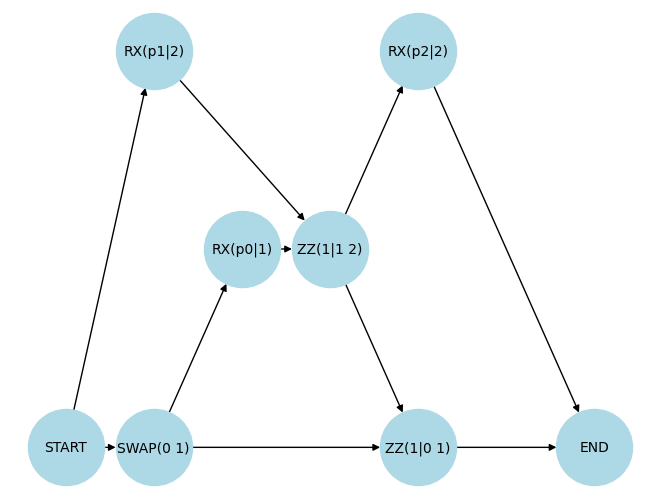

In [11]:
nx.draw(G,Position, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_color='black', arrows=True)# 绘制有向无环图


In [12]:
X

array([[1, 0, 0, 0, 0, 1, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 1],
       [0, 1, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 1, 1, 0],
       [0, 0, 0, 0, 1, 1, 1, 1]])

In [13]:
A

array([[0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [ ]:
node =[]

for each_layer in DAGCircuit(circuit).layering():
    each_nodes = DAGCircuit(each_layer).find_all_gate_node()
    each_nodes = sorted(each_nodes, key=lambda x: x.gate.name.lower())
    node.append(each_nodes)
node

In [ ]:
DAGCircuit(circuit).layering()[1]

In [ ]:
count =0 
for i in node:
    count+=len(i)

count

In [ ]:
Gates = []
Gates_list = []
for each_layer in DAGCircuit(circuit=circuit).layering():
    nodes = sorted(DAGCircuit(each_layer).find_all_gate_node(), key=lambda x: x.gate.name.lower())
    Gates.append(nodes)
    Gates_list.extend(nodes)

for i in Gates:
    print(i)
    
    

In [ ]:
Gates

In [ ]:
Gates_list

In [ ]:
[1 if i in Gates[1] else 0 for index, i in enumerate(Gates_list)]

In [ ]:
Gates[1]

In [ ]:
G = nx.DiGraph()
position = {}
for index,each_layer_node_a in enumerate(Gates):
    G.add_nodes_from(each_layer_node_a)
    print(f'第{index}层的{each_layer_node_a}被添加！')
    for each_node in each_layer_node_a:
        position[each_node] = (index, each_node.gate.obj_qubits[0])
        #print(each_node)
        obj_qubits = deepcopy(each_node.gate.obj_qubits)
        print(f'第{index}层,Gate={each_node},qubits={obj_qubits}')
        for layer in Gates[index+1:]:
            print(f'后续 layer={layer}')
            for each_layer_node_b in layer:
                #判断是否有交集
                if set(obj_qubits) & set(each_layer_node_b.gate.obj_qubits):
                    print('没有交集！')
                    G.add_edge(each_node, each_layer_node_b)
                    intersection = list(set(obj_qubits) & set(each_layer_node_b.gate.obj_qubits))
                    print(f'intersection={intersection}')
                    [obj_qubits.remove(i) for i in intersection]
                    if len(obj_qubits) == 0:
                        break
                    else:
                        continue
                else:
                    print(f'{each_node}与{each_layer_node_b}没有交集')
                        
# 绘制有向无环图
nx.draw(G, position, with_labels=True, node_size=700, node_color='lightblue', font_size=10, font_color='black', arrows=True)
plt.show()
adj_matrix = nx.adjacency_matrix(G).todense()
print("邻接矩阵:")
print(adj_matrix)

In [ ]:
Gates

In [ ]:
a = [0,1,2,3,4,5]
a[3:]